<a href="https://colab.research.google.com/github/gibsonx/CE888/blob/master/Assignment/sentiment_analysis_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -U tensorflow tensorflow_datasets tensorflow_text zhon bert-for-tf2 sentencepiece

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.4.1)
     |████████████████████████████████| 3.7MB 6.8MB/s 
     |████████████████████████████████| 3.4MB 40.0MB/s 
     |████████████████████████████████| 102kB 11.9MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 1.2MB 49.2MB/s 
  Created wheel for zhon: filename=zhon-1.1.5-cp36-none-any.whl size=84293 sha256=79b8234416281e2c4bd828de00b09d96f6b8392e412c879d8b215ee3fd564fba
  Stored in directory: /root/.cache/pip/wheels/0e/93/5a/ad2f403c359ba996e33c21bf18611d921413df9740ede2fcf4
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp36-none-any.whl size=30534 sha256=f6d08591ea6ea468d20f107190921329e768a7d51ef9a7781a516ad06a4becdd
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp36-none-any.whl size=7912 sha256=af1fedb1128f2

In [4]:
from google.colab import output
from google.colab import drive

import bert
import collections
import pathlib
import re
import string
import os
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import WordNetLemmatizer
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_datasets as tfds
import tensorflow_text as text

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from zhon import hanzi 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import csv

try:
    %tensorflow_version 2.x
except Exception:
    pass

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [68]:
drive.mount('/content/drive/')
base_dir = '/content/drive/MyDrive/tweeteval/datasets/'
hate_dir = base_dir + "hate"
irony_dir = base_dir + "irony"
offensive_dir = base_dir + "offensive"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [82]:
stop_words = stopwords.words('english')
new_words=['im']
for i in new_words:
  stop_words.append(i)
print(stop_words)  

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', string)

def preprocess_tweet_text(tweet):
    tweet = tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = tweet.translate(str.maketrans('', '', hanzi.punctuation))
    tweet = remove_emoji(tweet)
    tweet_tokens = word_tokenize(tweet)
    # Remove stopwords
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    return " ".join(filtered_words)

def readfile(text):
  pd_list = []
  with open(text,'r') as f:
    for tweet in f.read().splitlines():
      pd_list.append(tweet)   
  return pd_list


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [94]:
#Hate DataFrame
hate_dict_train = {'text': readfile(os.path.join(hate_dir,"train_text.txt")),
    'label': readfile(os.path.join(hate_dir,"train_labels.txt"))}
hate_dict_val = {'text': readfile(os.path.join(hate_dir,"val_text.txt")),
    'label': readfile(os.path.join(hate_dir,"val_labels.txt"))}
hate_dict_test = {'text': readfile(os.path.join(hate_dir,"test_text.txt")),
    'label': readfile(os.path.join(hate_dir,"test_labels.txt"))}

df_hate_train = pd.DataFrame(hate_dict_train)
df_hate_val = pd.DataFrame(hate_dict_train)
df_hate_test = pd.DataFrame(hate_dict_test)

hate_frames = [df_hate_train, df_hate_val, df_hate_test]
df_hate = pd.concat(hate_frames)
not_hate = df_hate[df_hate['label'] == '0']
hate = df_hate[df_hate['label'] == '1']

not_hate_text = " ".join(preprocess_tweet_text(review) for review in not_hate["text"])
hate_text = " ".join(preprocess_tweet_text(review) for review in hate["text"])

#Irony DataFrame
irony_dict_train = {'text': readfile(os.path.join(irony_dir,"train_text.txt")),
    'label': readfile(os.path.join(irony_dir,"train_labels.txt"))}
irony_dict_val = {'text': readfile(os.path.join(irony_dir,"val_text.txt")),
    'label': readfile(os.path.join(irony_dir,"val_labels.txt"))}
irony_dict_test = {'text': readfile(os.path.join(irony_dir,"test_text.txt")),
    'label': readfile(os.path.join(irony_dir,"test_labels.txt"))}

df_irony_train = pd.DataFrame(irony_dict_train)
df_irony_val = pd.DataFrame(irony_dict_val)
df_irony_test = pd.DataFrame(irony_dict_test)

irony_frames = [df_irony_train, df_irony_val, df_irony_test]
df_irony = pd.concat(irony_frames)
not_irony  = df_irony[df_irony['label'] == '0']
irony  = df_irony[df_irony['label'] == '1']

not_irony_text = " ".join(preprocess_tweet_text(review) for review in not_irony["text"])
irony_text = " ".join(preprocess_tweet_text(review) for review in irony["text"])

#Offensive DataFrame
offensive_dict_train = {'text': readfile(os.path.join(offensive_dir,"train_text.txt")),
    'label': readfile(os.path.join(offensive_dir,"train_labels.txt"))}
offensive_dict_val = {'text': readfile(os.path.join(offensive_dir,"val_text.txt")),
    'label': readfile(os.path.join(offensive_dir,"val_labels.txt"))}
offensive_dict_test = {'text': readfile(os.path.join(offensive_dir,"test_text.txt")),
    'label': readfile(os.path.join(offensive_dir,"test_labels.txt"))}

df_offensive_train = pd.DataFrame(offensive_dict_train)
df_offensive_val = pd.DataFrame(offensive_dict_val)
df_offensive_test = pd.DataFrame(offensive_dict_test)

offensive_frames = [df_offensive_train, df_offensive_val, df_offensive_test]
df_offensive = pd.concat(offensive_frames)
not_offensive  = df_offensive[df_offensive['label'] == '0']
offensive  = df_offensive[df_offensive['label'] == '1']

not_offensive_text = " ".join(preprocess_tweet_text(review) for review in not_offensive["text"])
offensive_text = " ".join(preprocess_tweet_text(review) for review in offensive["text"])



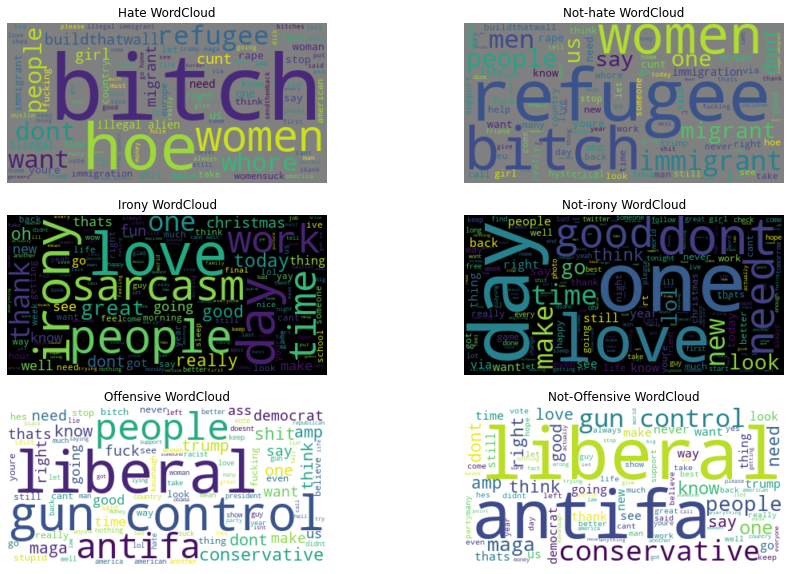

In [98]:
wordcloud_not_hate = WordCloud(max_words=100,background_color="grey").generate(not_hate_text)
wordcloud_hate = WordCloud(max_words=100,background_color="grey").generate(hate_text)

wordcloud_not_irony = WordCloud().generate(not_irony_text)
wordcloud_irony = WordCloud().generate(irony_text)

wordcloud_not_offensive = WordCloud(max_words=100,background_color="white").generate(not_offensive_text)
wordcloud_offensive = WordCloud(max_words=100,background_color="white").generate(offensive_text)

fig, axs = plt.subplots(3,2)
fig.set_figheight(10)
fig.set_figwidth(15)
axs[0,0].axis('off')
axs[0,0].set_title("Hate WordCloud")
axs[0,0].imshow(wordcloud_hate, interpolation='bilinear')
axs[0,1].set_title("Not-hate WordCloud")
axs[0,1].imshow(wordcloud_not_hate, interpolation='bilinear')
axs[0,1].axis('off')
axs[1,0].set_title("Irony WordCloud")
axs[1,0].imshow(wordcloud_irony, interpolation='bilinear')
axs[1,0].axis('off')
axs[1,1].set_title("Not-irony WordCloud")
axs[1,1].imshow(wordcloud_not_irony, interpolation='bilinear')
axs[1,1].axis('off')
axs[2,0].set_title("Offensive WordCloud")
axs[2,0].imshow(wordcloud_offensive, interpolation='bilinear')
axs[2,0].axis('off')
axs[2,1].set_title("Not-Offensive WordCloud")
axs[2,1].imshow(wordcloud_not_offensive, interpolation='bilinear')
axs[2,1].axis('off')

plt.show()
plt.close()

In [108]:
print(not_hate.shape[0])
print(hate.shape[0])

12152
8818
